![title](banner.jpg)

# COVID-19 X-ray Image Classification Project

## Importing Libraries

In [125]:
import numpy as np
import pandas as pd
import cv2
import h5py
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import binarize


## Improting Data

In [2]:
###################################################
# Run this only if you have the h5 files
# and don't want to process all the images again.
###################################################

with h5py.File('../project/data_train.h5', 'r') as hf:
    train_imgs = np.array(hf['imgs'])
    train_labels = np.array(hf['labels'])


with h5py.File('../project/data_test.h5', 'r') as hf:
    test_imgs = np.array(hf['imgs'])
    test_labels = np.array(hf['labels'])

## Image Visualization Block

In [3]:
def visualize_image(IMG_SET, IMG_LBL):
    try:
        if len(IMG_SET.shape) == 3:
            fig = plt.figure(figsize=(15,10))
            for i in range(10):
                ax = fig.add_subplot(1, 10, i+1)
                ax.imshow(IMG_SET[i])
                ax.set_title('label: '+str(IMG_LBL[i]))

                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

            fig.tight_layout()
            plt.show()
        
        elif len(IMG_SET.shape) == 2:
            fig = plt.figure(figsize=(15,10))
            HEIGHT = WIDTH = int(np.sqrt(IMG_SET.shape[1]))
            imgs = np.reshape(IMG_SET, (len(IMG_SET), HEIGHT, WIDTH))
            for i in range(10):
                ax = fig.add_subplot(1, 10, i+1)
                ax.imshow(imgs[i])
                ax.set_title('label: '+str(IMG_LBL[i]))

                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

            fig.tight_layout()
            plt.show()
        else:
            print('PLEASE PROVIDE IMAGE ARRAY IN SHAPE: (HEIGHT, WIDTH) or (Number of Images, HEIGHT, WIDTH)')
            
    except:
        print('Provide a valid image array!!!')

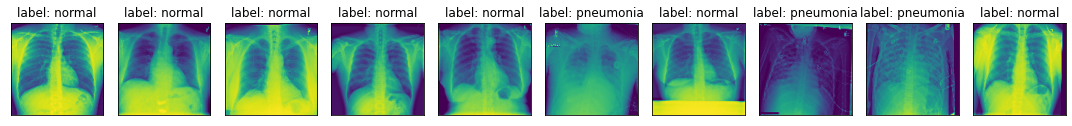

In [4]:
visualize_image(test_imgs, test_labels)

### Class distribution

From the bar plot, we can clearly see that there is a clear class imbalance in the training dataset. There is a very large number of occurances of **'Normal'** and **Pneumonia'** class compared to **'COVID-19'** class. This imbalance would likely affect any model that is built and trained on this dataset. We may need to explore some approaches for data augmentation. But we will look into that later.

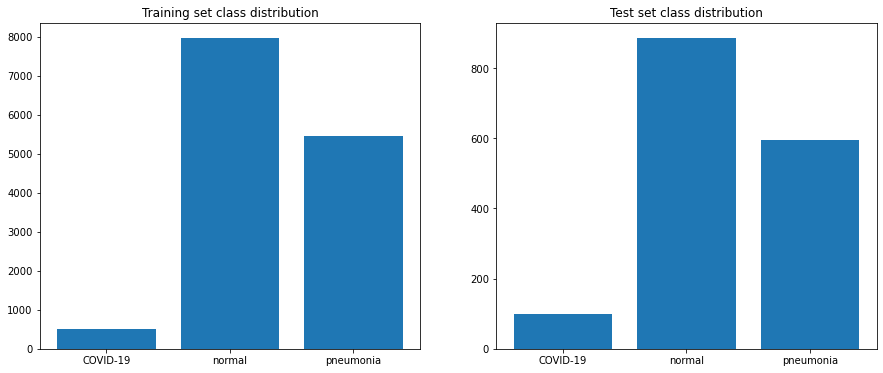

In [108]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
plt.bar(np.unique(train_labels, return_counts=True)[0], np.unique(train_labels, return_counts=True)[1])
ax1.set_title('Training set class distribution')

ax2 = fig.add_subplot(122)
plt.bar(np.unique(test_labels, return_counts=True)[0], np.unique(test_labels, return_counts=True)[1])
ax2.set_title('Test set class distribution')

plt.show()

# Data Pre-processing

Principle Component Analysis (PCA) has two important requirements:
1. The number of samples has to be quite larger than the number of dimensions.
2. The images must be vectorized.

The native image size of our dataset is 128px by 128px. Which means when vectorized, the number of dimensions will be 16384. Which is a lot bigger than the total sample we have for training, 13942. For that reason, we will resize the images to 64x64 pixels, which is a reasonable size to work with. We are hoping this size will retain some of the distinguishing features and will help us to separate the classes. Then we will vectorize our image sets. So it will be number of images by total number of dimensions.```Training set dimensions: 13942 x 4096``` and ```Test set dimensionss: 1579 x 4096```.

## Image Resizing

In [5]:
def resize_images(IMG_SET, HEIGHT, WIDTH):
    imgs = []
    for img in tqdm(IMG_SET, leave=False, desc='Resizing images: ', ncols='100%'):
        resized_img = cv2.resize(img, dsize=(HEIGHT, WIDTH), interpolation=cv2.INTER_CUBIC)
        imgs.append(resized_img)
        
    imgs = np.array(imgs)    
    return imgs

In [6]:
train_imgs_resized = resize_images(train_imgs, 64, 64)

test_imgs_resized = resize_images(test_imgs, 64, 64)

## Image Vectorising

In [7]:
def vectorise_img(IMG_SET):
    shp_dim1 = len(IMG_SET)
    shp_dim2 = IMG_SET.shape[1]*IMG_SET.shape[2]
    imgs = np.reshape(IMG_SET, (shp_dim1, shp_dim2))
    
    return imgs

In [8]:
train_imgs_vector = vectorise_img(train_imgs_resized)
test_imgs_vector = vectorise_img(test_imgs_resized)

## Principal Component Analysis (PCA) Implementation

* Principal component analysis (PCA) finds a new set of dimensions into which we reproject the data. This can be seen as rotating the data around the current axes.
* The new dimensions are oriented such that the first one captures the most possible variation, the second one captures the second most variation, etc
* The new axis are orthogonal to each other (i.e. at right angles)
* We get back as many principal components as we have original dimensions (i.e. we don't have to reduce the dimensions)
* We can project points into and out of our PCA space, reprojecting back out will give us our original data back
* PCA will subtract the mean from the data when computing the new set of axes. If we pass is non-centred data, PCA will remove the mean for us (and return it), otherwise we can do this before we pass it in.

### Creating PCA object and fitting the data

In [9]:
# Creating the PCA object which will be used to fit and transform the data
pca = decomposition.PCA()
# Fitting and transforming the dataset
pca.fit(train_imgs_vector)
transformed = pca.transform(train_imgs_vector)

PCA calculates the ```Eigenvectors```, a unit vector representing the direction of variance in the data and ```Eigenvalues``` a scalar value for each eigenvector which represents the amount of variance in each component. We can access this value from out ```pca``` object. Let's examine some of these.

In [109]:
print("Components:")
print(f"Number of components we get back: {len(pca.components_)}")
print(pca.components_)
print()
print("Eignevalues:")
print(pca.explained_variance_)
print()
print("Percentage of variance explained:")
print(pca.explained_variance_ratio_)

Components:
Number of components we get back: 4096
[[ 1.06586858e-03  3.60309723e-03  4.04769059e-03 ...  1.92188751e-02
   1.66361591e-02  1.29946444e-02]
 [-1.25429103e-02 -1.20076844e-02 -1.24592514e-02 ...  2.54614986e-02
   2.15184057e-02  1.71698041e-02]
 [-2.18137179e-02 -8.18888884e-03 -6.08306373e-03 ...  1.84523504e-02
   2.02108989e-02  1.32831249e-02]
 ...
 [-7.17626779e-04  2.46773004e-03  5.09668796e-04 ... -1.72189210e-03
  -7.52053707e-05  8.42748304e-04]
 [-1.30025779e-03  2.46527494e-03 -9.17066499e-05 ... -5.17048250e-04
   3.49771146e-03 -5.11004175e-06]
 [-5.50240443e-04  5.95400136e-03 -6.40672010e-03 ... -4.50838817e-04
   1.01524465e-03 -1.03694024e-03]]

Eignevalues:
[2.31425768e+06 8.47554048e+05 7.11103130e+05 ... 1.84735045e+00
 1.84617583e+00 1.78059298e+00]

Percentage of variance explained:
[2.62729598e-01 9.62198532e-02 8.07290566e-02 ... 2.09723250e-07
 2.09589898e-07 2.02144506e-07]


```explained_variance_ratio_``` describes the percetnage of variance explained by each new dimension. We can plot this as a cumulative sum to visualize what each dimension contribute to explaining the variance.

### Visualizing the explained variance in the components

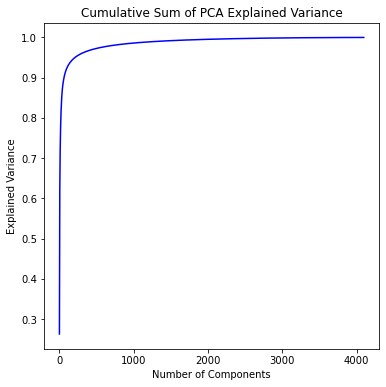

In [10]:
cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(cumulative_sum, c = 'b')
ax.set_title('Cumulative Sum of PCA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Components')

plt.show()

### Label recoding block

In [11]:
# Codeblock to recode the data. Not necessary for the classifiers.
def recode_labels(labels):
    code_dict = {'pneumonia':1, 'normal': 2, 'COVID-19': 3}
    return np.array([code_dict[label] for label in labels])


In [12]:
top90 = np.where(cumulative_sum > 0.90)[0][0]
print('90% in ' + '%d' % (top90+1) + ' components')
top95 = np.where(cumulative_sum > 0.95)[0][0]
print('95% in ' + '%d' % (top95+1) + ' components')
top99 = np.where(cumulative_sum > 0.99)[0][0]
print('99% in ' + '%d' % (top99+1) + ' components')

90% in 63 components
95% in 209 components
99% in 1287 components


When we look at the number of dimensions that it takes to explain 90%, 95% and 99% of the variance, we see that only 63 components are required to explain 90% of the variance. 209 components describes up to 95% of the variance. And 1287 components describes 99% of the variance, which is almost all of the data. So, this leads us to believe that we can dramatically reduce the dimensionality of the dataset and can work with even the first 63 or 209 components. So we will select the first 209 components from the transformed data.

In [13]:
transformed_train_95 = transformed[:, 0:top95]

transformed_test = pca.transform(test_imgs_vector)
transformed_test_95 = transformed_test[:, 0:top95]

distance = np.sqrt(np.sum((transformed_train_95 - transformed_test_95[0,:])**2, axis=1))

index_min = np.argmin(distance)

print(train_labels[index_min])
print(test_labels[0])

normal
normal


### Visualizing the components

Text(0.5, 1.0, 'First Two PCA Components')

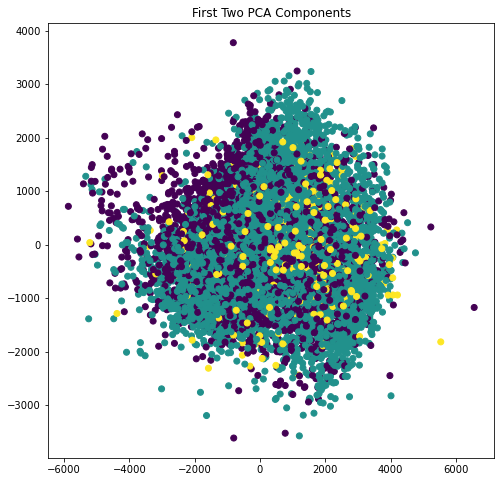

In [14]:
y = recode_labels(train_labels)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(transformed_train_95[:,0], transformed_train_95[:,1], c=y);
ax.set_title('First Two PCA Components')

## Model Evaluation Block

In [110]:
#How sensitive is the classifier to detect positive cases (Recall)
def sensitivity(Y_test, Y_pred):
    sensitivity = metrics.recall_score(Y_test, Y_pred, average = None)
    #TP / float(TP + FN)
    #print('Sensitivity: {}'.format(sensitivity))
    labels = np.unique(Y_test)
    print('Sensitivity/Recall')
    [print('{:20s}:\t{:4.2f}'.format(l, s)) for l, s in zip(labels, sensitivity)]
    print()

#How specific is the classifier in predicting positive instances (best possible value is 1)
#for both sensitivity and specificity the best possible value is 1. (based on the values the 
#classifier can be called as highly specific, but not highly sensitive or ...)
def specificity(Y_test, Y_pred):
    # calculate the confusion matrix and save it into confusion object
    confusion = metrics.confusion_matrix(Y_test, Y_pred)
    # slice the confusion object into four: True Positive, True Negative, False Positive & False Negative
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 1]
    specificity = TN / float(TN + FP)
    print('Specificity:\t{:4.2f}\n'.format(specificity))

#When the actual value is negative, how often is the prediction incorrect
def falsePositive_rate(Y_test, Y_pred):
    # calculate the confusion matrix and save it into confusion object
    confusion = metrics.confusion_matrix(Y_test, Y_pred)
    # slice the confusion object into four: True Positive, True Negative, False Positive & False Negative
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 1]
    fpr = FP / float(TN + FP)
    print('False Positive Rate:\t{:.2f}\n'.format(fpr))

#When a positive value is predicted, how often is the prediction correct
def precision(Y_test, Y_pred):
    precision = metrics.precision_score(Y_test, Y_pred, average= None)
    labels = np.unique(Y_test)
    print('Precision')
    [print('{:20s}:\t{:4.2f}'.format(l, p)) for l, p in zip(labels, precision)]
    print()

##################################################################################
## This code block will evaluate the model based on the following metrics:
## - Accuracy
## - Classification error
## - Sensitivity/Recall
## - Precisison
## - Specificity
## - False Postive Rate
##################################################################################

def eval_model(model, X_train, Y_train, X_test, Y_test):
    Y_pred = model.predict(X_test)
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance');
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Test Set Performance');
    pred = model.predict(X_test)
    print('Test Accuracy:\t{:4.2f}%'.format(sum((Y_pred == test_labels)/len(test_labels))*100))
    #(FP + FN) / float(TP + TN + FP + FN)
    print('Classification Error:\t{:4.2f}%'.format((1-sum(Y_pred == test_labels)/len(test_labels))*100))
    
    sensitivity(Y_test, Y_pred)
    precision(Y_test, Y_pred)
    specificity(Y_test, Y_pred)
    falsePositive_rate(Y_test, Y_pred)

    print()

## Classification with PCA implementation

KNN, SVM and Naive Bayes implementation based on the PCA dimension reduction technique

### K-Nearest Neighbors Classifier

Test Accuracy:	80.18%
Classification Error:	19.82%
Sensitivity/Recall
COVID-19            :	0.16
normal              :	0.88
pneumonia           :	0.79

Precision
COVID-19            :	0.73
normal              :	0.83
pneumonia           :	0.76

Specificity:	0.33

False Positive Rate:	0.67




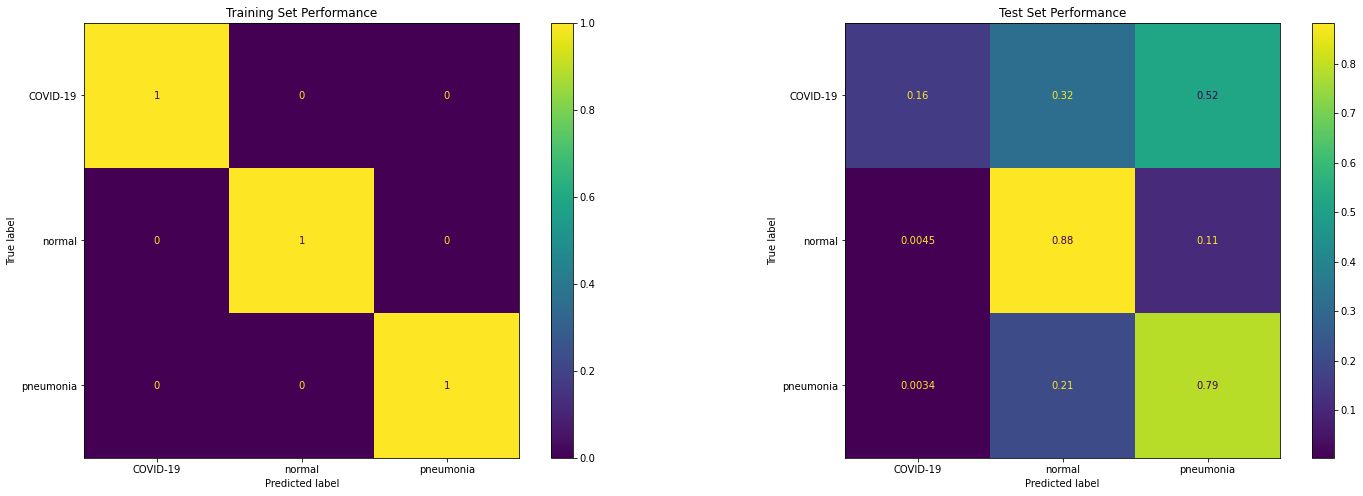

In [84]:
parameters = {'weights':('uniform', 'distance'), 'metric': ('euclidean', 'manhattan', 'minkowski')}
cknn_pca = KNeighborsClassifier(n_jobs=-1)
clf = GridSearchCV(cknn_pca, parameters)
clf.fit(transformed_train_95, train_labels)
eval_model(clf.best_estimator_, transformed_train_95, train_labels, transformed_test_95, test_labels)

### Support Vector Machine Classifier

Test Accuracy:	84.17%
Classification Error:	15.83%
Sensitivity/Recall
COVID-19            :	0.38
normal              :	0.89
pneumonia           :	0.85

Precision
COVID-19            :	0.86
normal              :	0.87
pneumonia           :	0.79

Specificity:	0.60

False Positive Rate:	0.40




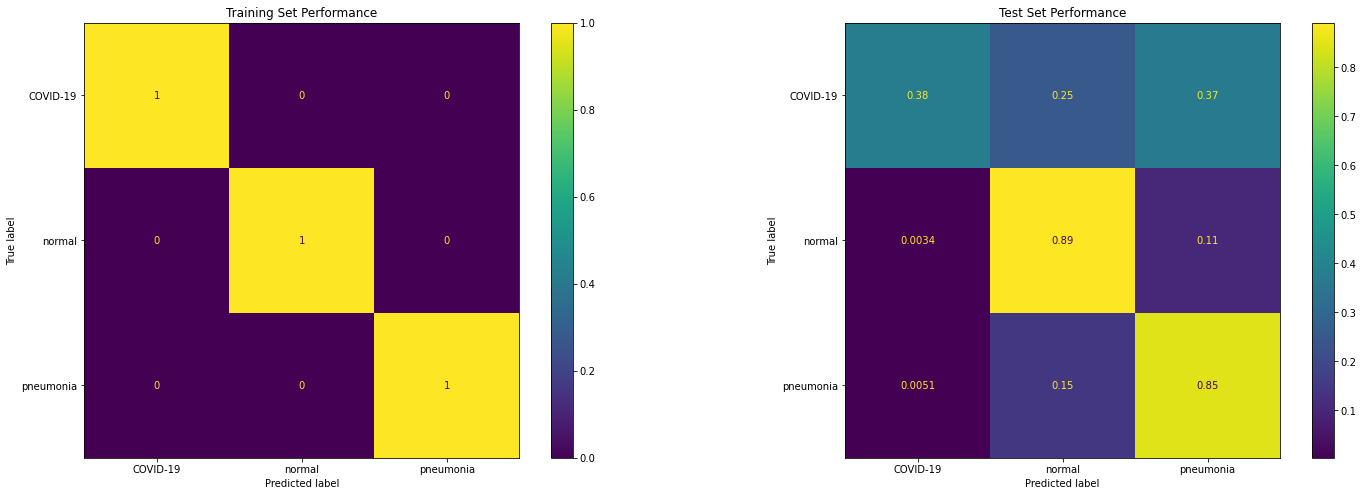

In [88]:
parameters = {'kernel':['rbf', 'sigmoid']}
svm_pca = svm.SVC(C = 1e5)
clf = GridSearchCV(svm_pca, parameters)
clf.fit(transformed_train_95, train_labels)
eval_model(clf.best_estimator_, transformed_train_95, train_labels, transformed_test_95, test_labels)

### Naive Bayes Classifier

Test Accuracy:	67.07%
Classification Error:	32.93%
Sensitivity/Recall
COVID-19            :	0.15
normal              :	0.67
pneumonia           :	0.76

Precision
COVID-19            :	0.58
normal              :	0.78
pneumonia           :	0.57

Specificity:	0.35

False Positive Rate:	0.65




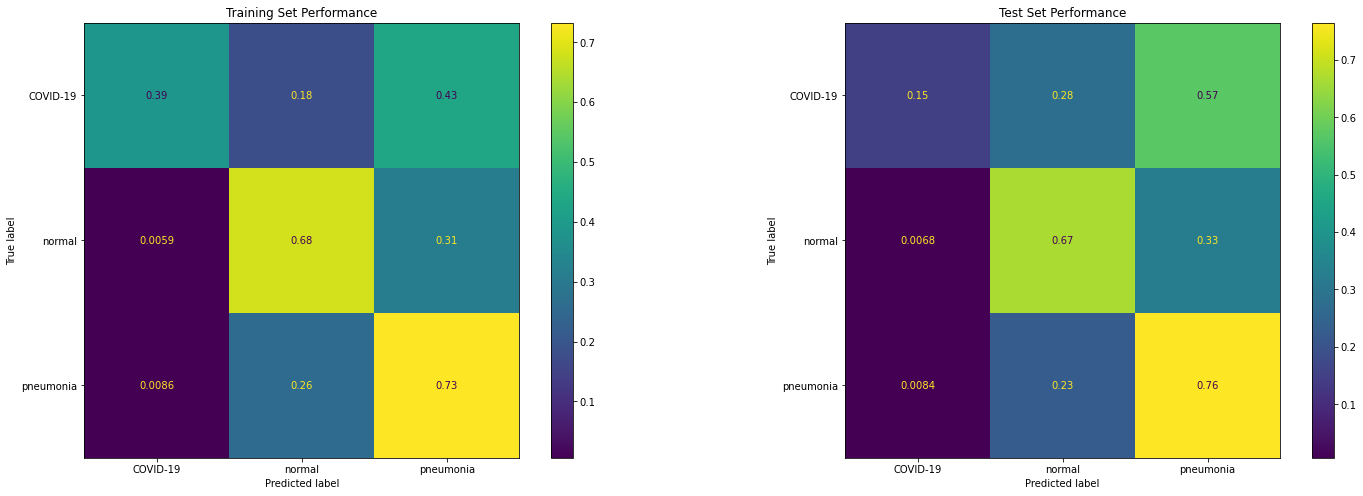

In [94]:
parameters = {}
nb_pca = GaussianNB()
clf = GridSearchCV(nb_pca, parameters)
clf.fit(transformed_train_95, train_labels)
eval_model(clf.best_estimator_, transformed_train_95, train_labels, transformed_test_95, test_labels)

## Linear Discriminant Analysis (LDA) Implementation

LDA is used to separate the classes and make the class boundary more apparent. So we will combine LDA with PCA to better divide up the classes.

In [95]:
pca_coeff_for_lda = 4096 - len(np.unique(train_labels))
print(pca_coeff_for_lda)
transformed_train_for_lda = transformed[:, 0:pca_coeff_for_lda]
transformed_test_for_lda = transformed_test[:, 0:pca_coeff_for_lda]

4093


Text(0.5, 1.0, 'First Two LDA Components')

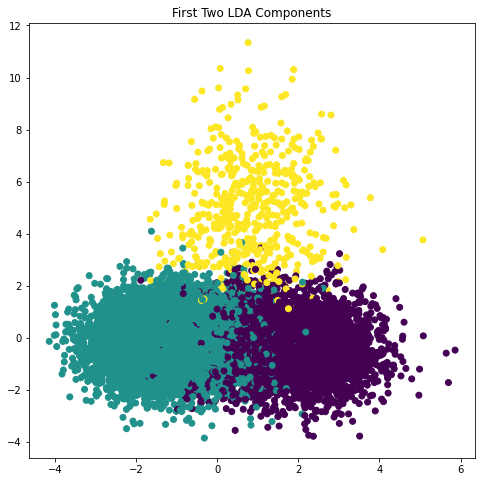

In [96]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(transformed_train_for_lda, train_labels)
lda_train = lda.transform(transformed_train_for_lda)
lda_test = lda.transform(transformed_test_for_lda)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(lda_train[:,0], lda_train[:,1], c=y);
ax.set_title('First Two LDA Components')

## Classification with PCA and LDA combined implementation

### K-Nearest Neighbors Classifier

Test Accuracy:	73.08%
Classification Error:	26.92%
Sensitivity/Recall
COVID-19            :	0.23
normal              :	0.79
pneumonia           :	0.73

Precision
COVID-19            :	0.33
normal              :	0.79
pneumonia           :	0.69

Specificity:	0.35

False Positive Rate:	0.65




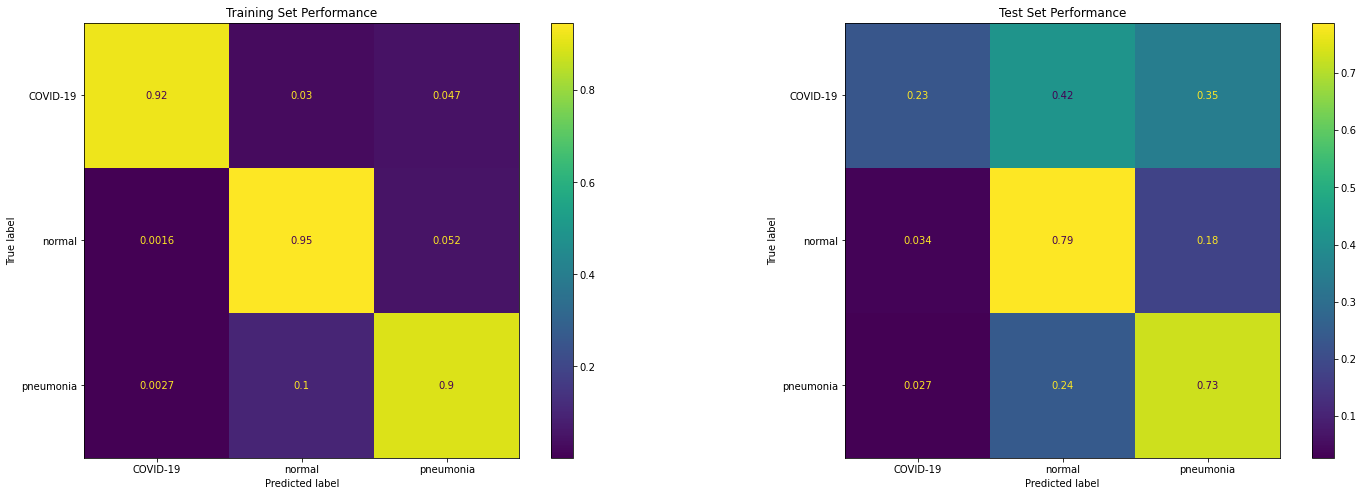

In [97]:
parameters = {'weights':('uniform', 'distance'), 'metric': ('euclidean', 'manhattan', 'minkowski')}
cknn_pca_lda = KNeighborsClassifier(n_jobs=-1)
clf = GridSearchCV(cknn_pca_lda, parameters)
clf.fit(lda_train, train_labels)
eval_model(clf.best_estimator_, lda_train, train_labels, lda_test, test_labels)

### Support Vector Machine Classifier

Test Accuracy:	74.29%
Classification Error:	25.71%
Sensitivity/Recall
COVID-19            :	0.23
normal              :	0.79
pneumonia           :	0.76

Precision
COVID-19            :	0.29
normal              :	0.81
pneumonia           :	0.71

Specificity:	0.37

False Positive Rate:	0.63




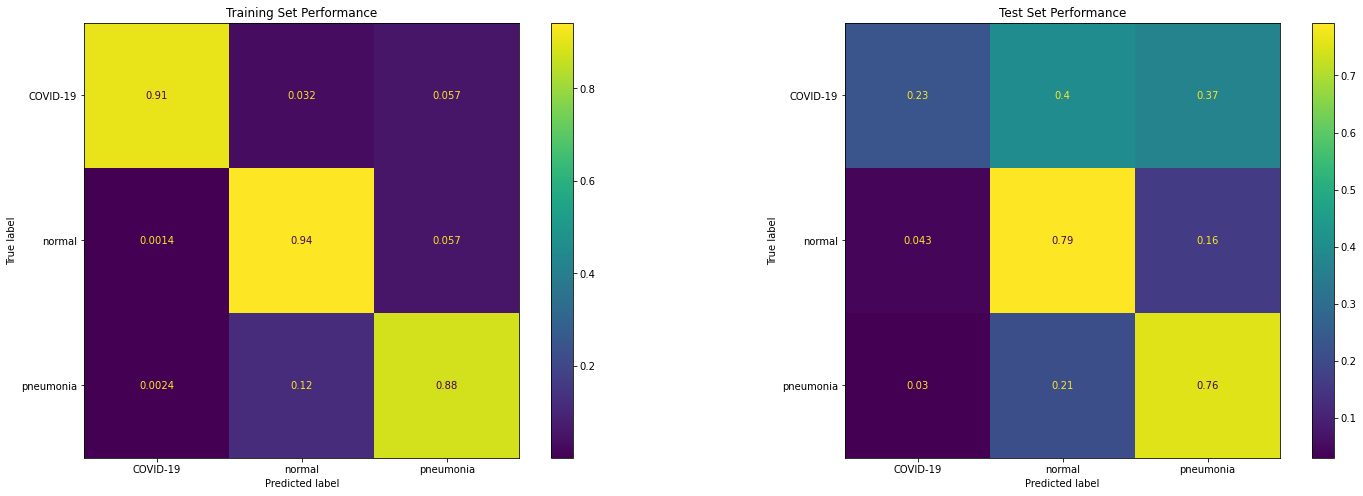

In [98]:
parameters = {'kernel':['rbf', 'sigmoid']}
svm_pca_lda = svm.SVC(C = 1e5)
clf = GridSearchCV(svm_pca_lda, parameters)
clf.fit(lda_train, train_labels)
eval_model(clf.best_estimator_, lda_train, train_labels, lda_test, test_labels)

### Naive Bayes Classifier

Test Accuracy:	74.60%
Classification Error:	25.40%
Sensitivity/Recall
COVID-19            :	0.22
normal              :	0.80
pneumonia           :	0.76

Precision
COVID-19            :	0.32
normal              :	0.81
pneumonia           :	0.71

Specificity:	0.35

False Positive Rate:	0.65




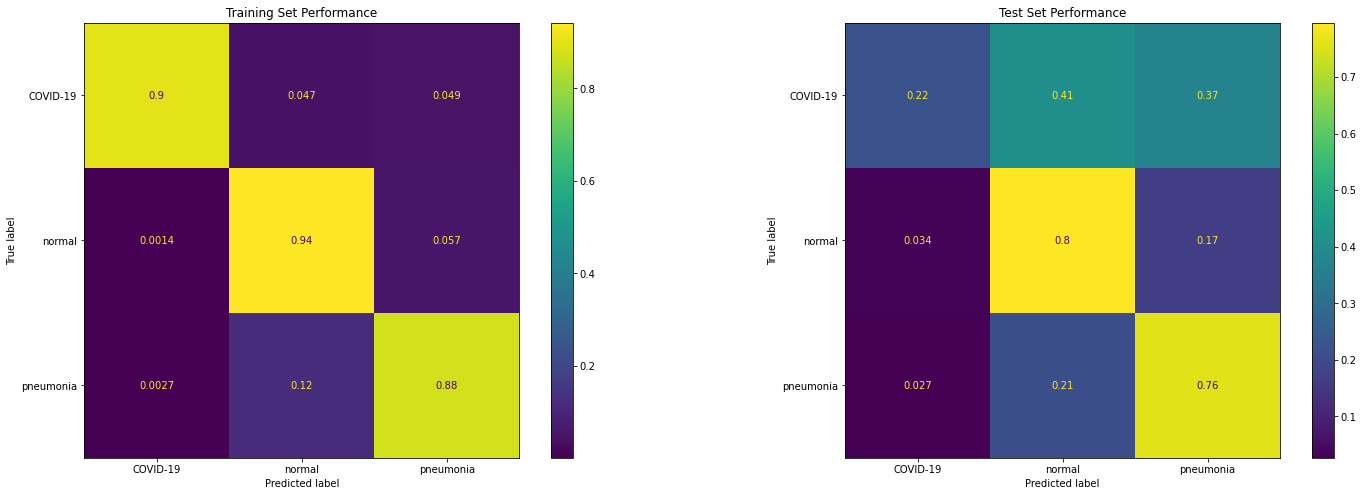

In [100]:
parameters = {}
nb_pca_lda = GaussianNB()
clf = GridSearchCV(nb_pca_lda, parameters)
clf.fit(lda_train, train_labels)
eval_model(clf.best_estimator_, lda_train, train_labels, lda_test, test_labels)

## Classification with only LDA dimension reduction

In [101]:
lda_only = discriminant_analysis.LinearDiscriminantAnalysis()
lda_only.fit(train_imgs_vector, train_labels)
lda_only_train = lda_only.transform(train_imgs_vector)
lda_only_test = lda_only.transform(test_imgs_vector)

### K-Nearest Neighbors Classifier

Test Accuracy:	73.34%
Classification Error:	26.66%
Sensitivity/Recall
COVID-19            :	0.22
normal              :	0.79
pneumonia           :	0.74

Precision
COVID-19            :	0.31
normal              :	0.79
pneumonia           :	0.69

Specificity:	0.35

False Positive Rate:	0.65




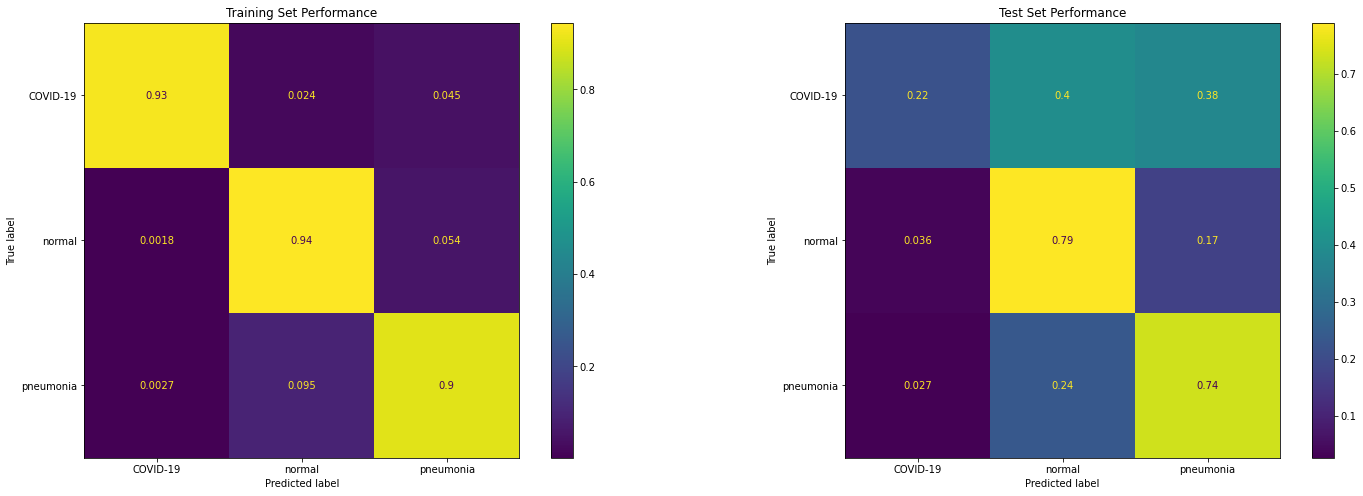

In [102]:
parameters = {'weights':('uniform', 'distance'), 'metric': ('euclidean', 'manhattan', 'minkowski')}
cknn_lda = KNeighborsClassifier(n_jobs=-1)
clf = GridSearchCV(cknn_lda, parameters)
clf.fit(lda_only_train, train_labels)
eval_model(clf.best_estimator_, lda_only_train, train_labels, lda_only_test, test_labels)

### Support Vector Machine Classifier

Test Accuracy:	74.35%
Classification Error:	25.65%
Sensitivity/Recall
COVID-19            :	0.23
normal              :	0.79
pneumonia           :	0.76

Precision
COVID-19            :	0.31
normal              :	0.81
pneumonia           :	0.71

Specificity:	0.37

False Positive Rate:	0.63




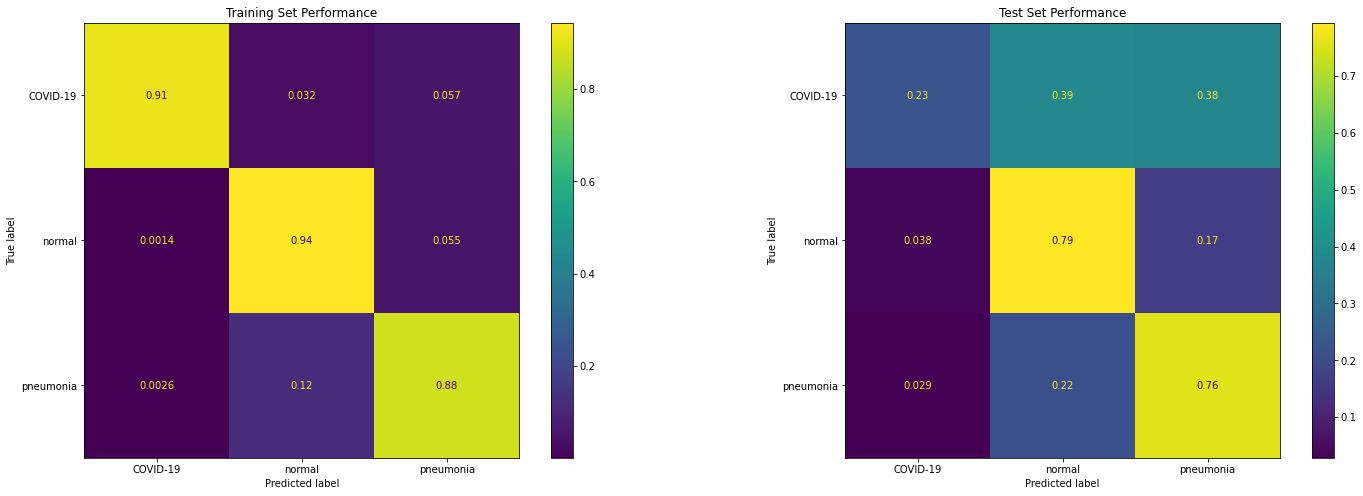

In [103]:
parameters = {'kernel':['rbf', 'sigmoid']}
svm_lda = svm.SVC(C = 1e5)
clf = GridSearchCV(svm_lda, parameters)
clf.fit(lda_only_train, train_labels)
eval_model(clf.best_estimator_, lda_only_train, train_labels, lda_only_test, test_labels)

### Naive Bayes Classifier

Test Accuracy:	74.60%
Classification Error:	25.40%
Sensitivity/Recall
COVID-19            :	0.21
normal              :	0.79
pneumonia           :	0.76

Precision
COVID-19            :	0.31
normal              :	0.81
pneumonia           :	0.71

Specificity:	0.33

False Positive Rate:	0.67




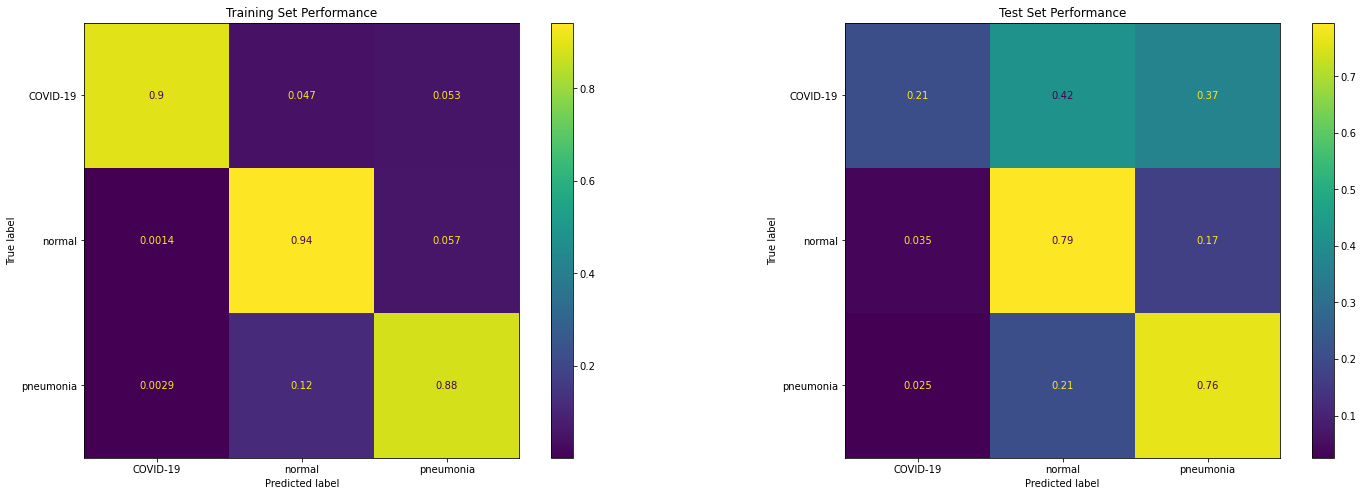

In [104]:
parameters = {}
nb_lda = GaussianNB()
clf = GridSearchCV(nb_lda, parameters)
clf.fit(lda_only_train, train_labels)
eval_model(clf.best_estimator_, lda_only_train, train_labels, lda_only_test, test_labels)

### Receiver Operating Characteristic (ROC)

In [154]:
def clf_roc(clf, X_train, y_train, X_test, y_test, n_classes = 3):
    labels = ['Pneumonia', 'Normal', 'COVID-19']
    c = ['#3742fa', '#2ed573', '#ff6348']
    classifier = OneVsRestClassifier(clf)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 8))
    lw = 2
    for i, (f, t) in enumerate(zip(fpr, tpr)):
        plt.plot(fpr[f], tpr[t], lw=lw, c=c[i], label='ROC curve for {} (area = {:.2f})'.format(labels[i], roc_auc[f]))
        if i==2:
            break
    plt.plot([0, 1], [0, 1], color='#2f3542', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [122]:
y_train = recode_labels(train_labels)
y_test = recode_labels(test_labels)

y_train = label_binarize(y_train, classes=[1,2,3])
y_test = label_binarize(y_test, classes=[1,2,3])

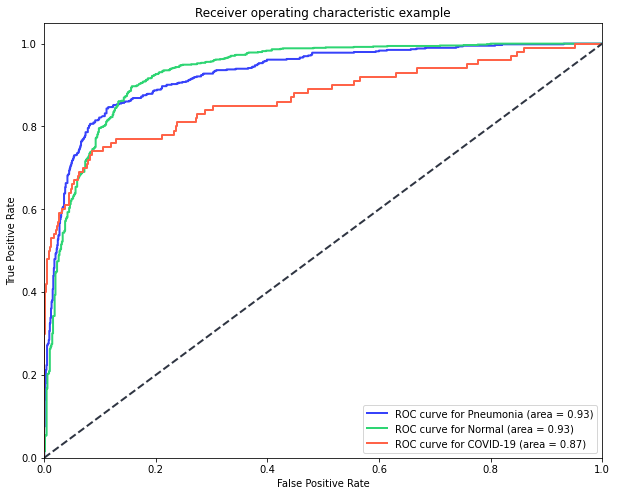

In [157]:
svm_pca = svm.SVC(kernel='rbf', C = 1e5, probability=True)
clf_roc(svm_pca, transformed_train_95, y_train, transformed_test_95, y_test)